# NLP - Classification and Sentiment Analysis of Reddit Posts

## Part 5: Sentiment Analysis

Part 1: Web API Data Collection <br>
Part 2: Exploratory Data Analysis <br>
Part 3: Baseline Classification Models and Zero Shot Classification  <br>
Part 4: PyCaret Classification Models <br>
Part 5: Sentiment Analysis <br>

---

In part 5, sentiment analysis were run to understand sentiments across the two subreddits, 'Google' and 'Apple'.

Four different sentiment analysis tools were used.
1. [Vader (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment#about-the-scoring)
2. [spaCy](https://spacy.io/usage/spacy-101)
3. Hugging Face [RoBERTa Base Model](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment)
4. Hugging Face [Emotion English DistilRoBERTa Base Model](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base?text=shut+down)

In [210]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from transformers import pipeline

## Import Cleaned Data

In [16]:
data = pd.read_csv('Cleaned Datasets/cleaned_dataset', usecols=['text','subreddit'])
print(data.shape)
data.head()

(36057, 2)


,text,subreddit
0,frauenrztin mnchen zentrum schwangerenvorsorge,google
1,petition to save stadia i do not have high exp...,google
2,google stadia will be shutting down in january...,google
3,google will not let you create an email withou...,google
4,recover android backup with different resoluti...,google


In [17]:
data.dropna(inplace=True,axis=0)
print(data.shape)

(36054, 2)


## Vader

In [25]:
# Run sentiment analysis using vader, store the compound polarity score
vader = SentimentIntensityAnalyzer()
data['vader_polarity_score'] = data.progress_apply(lambda row:vader.polarity_scores(row['text'])['compound'],axis=1)

100%|███████████████████████████████████| 36054/36054 [00:26<00:00, 1384.57it/s]


In [28]:
# Define a function to return sentiment label based on polarity score
def extract_sentiment(score):
    if score>0:
        return 'positive'
    elif score<0:
        return 'negative'
    else:
        return 'neutral'

In [37]:
# Label the sentiment using polarity scores from vader
data['vader_sentiment'] = data.progress_apply(lambda row: extract_sentiment(row['vader_polarity_score']),axis=1)

100%|██████████████████████████████████| 36054/36054 [00:00<00:00, 54731.68it/s]


In [237]:
# Define a function to plot the sentiment distributions in the two subreddits
def sentiment_plot(df,col):
    fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True,figsize = (15,5))
    
    df1 = df[df['subreddit']=='google']
    df2 = df[df['subreddit']=='apple']
    
    p1 = sns.barplot(x=df1[col].value_counts().index, y=df1[col].value_counts(normalize=True),ax=ax[0])
    p1.set_title('Sentiments in Google Subreddit', fontsize=12)
    p1.set_ylabel('Percentage of Posts', fontsize=12)
    p1.set_ylim(0,0.8)
    p1.bar_label(p1.containers[0],fmt='%.2f');

    p2 = sns.barplot(x=df2[col].value_counts().index, y=df2[col].value_counts(normalize=True),ax=ax[1])
    p2.set_title('Sentiments in Apple Subreddit', fontsize=12)
    p2.set_ylabel('Percentage of Posts', fontsize=12)
    p2.bar_label(p2.containers[0],fmt='%.2f');

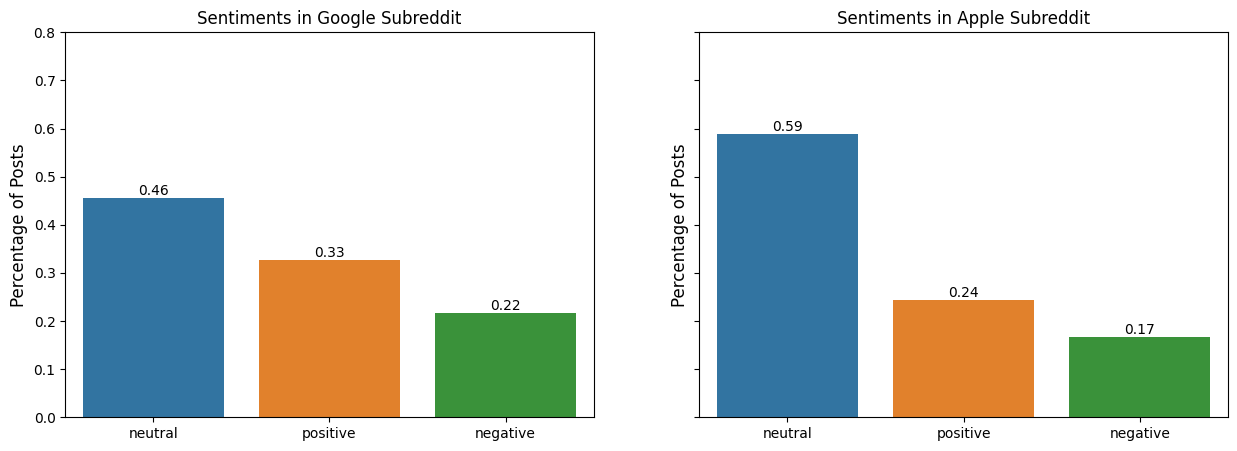

In [238]:
sentiment_plot(data,'vader_sentiment')

**Summary of Results**
- Majority of the posts are neutral in sentiment.
- There are more positive posts than negative posts.

## spaCy

In [ ]:
# Run sentiment analysis using spaCy, store the polarity score
spacy = spacy.load('en_core_web_sm')
spacy.add_pipe('spacytextblob')
data['spacy_polarity_score'] = data.progress_apply(lambda row:spacy(row['text'])._.polarity,axis=1)

In [116]:
# Convert polarity score to sentiment labels
data['spacy_sentiment'] = data.progress_apply(lambda row: extract_sentiment(row['spacy_polarity_score']),axis=1)

100%|██████████████████████████████████| 36054/36054 [00:01<00:00, 34253.01it/s]


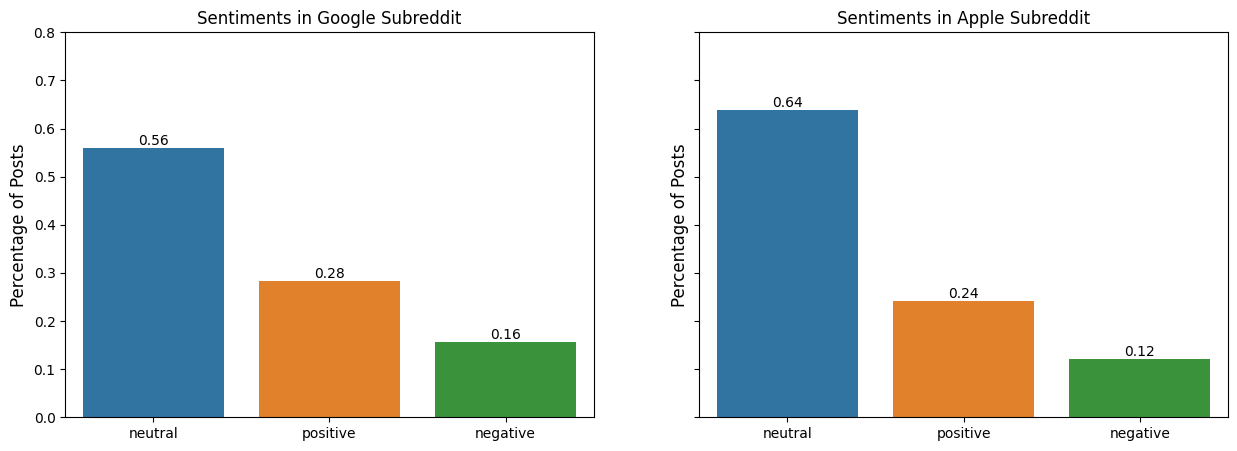

In [239]:
# Distribution plot
sentiment_plot(data,'spacy_sentiment')

Results were pretty similar to results from vader.

## Hugging Face Transformer - RoBERTa Base Model

This is a roBERTa-base model trained on ~58M tweets and finetuned for sentiment analysis.


In [135]:
# Filter out short text for sentiment analysis in transformer, since the model can't take in long text.
data['short_text']=[len(row['text'])<512 for index,row in data.iterrows()]
short_text_data = data[data['short_text']]

In [10]:
# Run sentiment analysis, results dictionary are returned (0 -> Negative; 1 -> Neutral; 2 -> Positive)
sentiment_analysis = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")
short_text_data['transformer_result'] = short_text_data.progress_apply(lambda row:sentiment_analysis(row['text']),axis=1)

In [151]:
# Extract the sentiment labels from results dictionary and map the labels accordingly
short_text_data['transformer_label'] = [row['transformer_result'][0]['label'] for index,row in short_text_data.iterrows()]
short_text_data['transformer_label'] = short_text_data['transformer_label'].map({'LABEL_0':'negative','LABEL_1':'neutral','LABEL_2':'positive'})

/var/folders/t3/8nf6b8z946b831z2hkj3fdkw0000gn/T/ipykernel_12804/580520286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_text_data['transformer_label'] = [row['transformer_result'][0]['label'] for index,row in short_text_data.iterrows()]


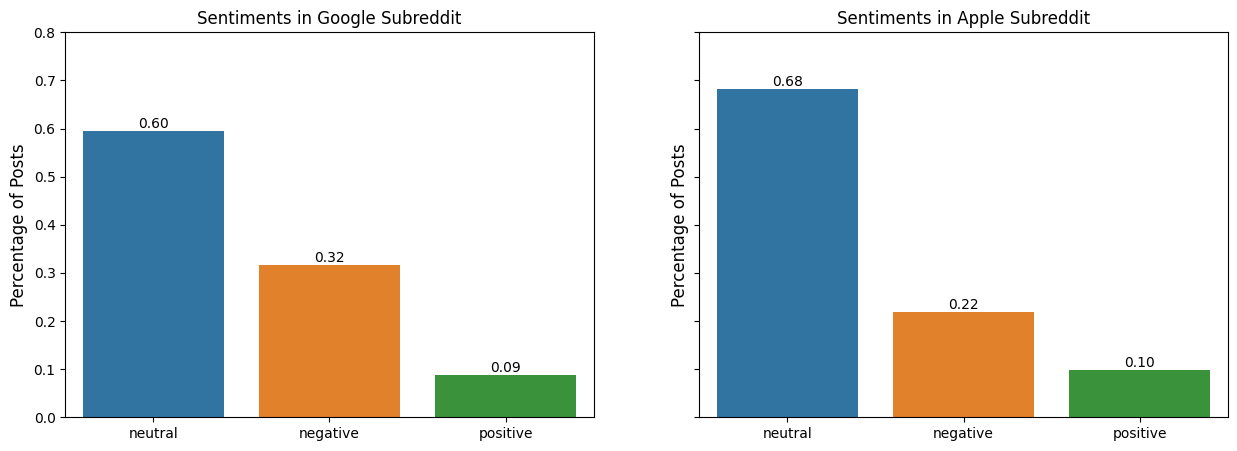

In [240]:
# Plot the distribution
sentiment_plot(short_text_data,'transformer_label')

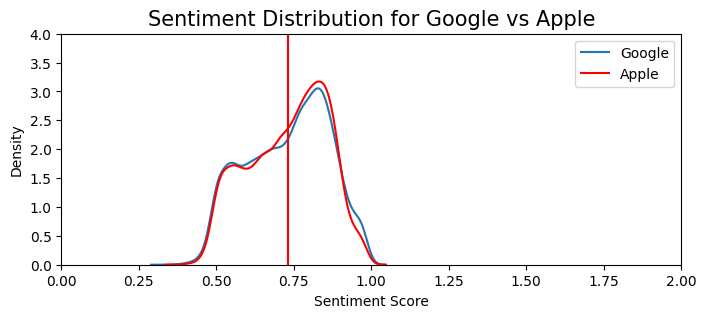

In [241]:
# Extract sentiment scores
short_text_data['transformer_score'] = [row['transformer_result'][0]['score'] for index,row in short_text_data.iterrows()]

## Plot distribution of sentiment score
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
df1 = short_text_data[short_text_data['subreddit']=='google']
df2 = short_text_data[short_text_data['subreddit']=='apple']

# Distribution plot for google
sns.kdeplot(df1['transformer_score'], ax = axs, label = 'Google')
axs.set_title('Sentiment Distribution for Google vs Apple', size = 15)
axs.set_xlabel('Sentiment Score')
axs.set_ylabel('Density')
axs.set_ylim(0,4)
axs.set_xlim(0,2)
axs.vlines(df1['transformer_score'].mean(), 0, 9, color = 'blue')

# Overlay with distribution plot for apple
sns.kdeplot(df2['transformer_score'], ax = axs, color = 'red', label = 'Apple')
axs.vlines(df2['transformer_score'].mean(), 0, 9, color = 'red')
plt.legend();

**Summary of Results**
- Model from Hugging Face Transformer produced different results from vader and spaCy.
- Similarity among all was that majority of the posts are neutral in sentiment.
- Difference was that Hugging Face Transformer labelled more negative sentiments than the other two.
- If we compare between Apple and Google, Google has more negative sentiments.

## Hugging Face Transformer - Emotion English DistilRoBERTa Base Model

To understand the sentiments at a more granular level instead of just positive and negative sentiments, Emotion English DistilRoBERTa Base Model was used. It was trained on 6 diverse datasets and predicts Ekman's 6 basic emotions (anger, disgust, fear, joy, sadness, surprise), plus a neutral class.

In [168]:
# Run sentiment analysis and store the result dictionary
emotion_analysis = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")
short_text_data['emotion_result'] = short_text_data.progress_apply(lambda row:emotion_analysis(row['text']),axis=1)

100%|███████████████████████████████████| 35362/35362 [1:35:12<00:00,  6.19it/s]
/var/folders/t3/8nf6b8z946b831z2hkj3fdkw0000gn/T/ipykernel_12804/2531047711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_text_data['emotion_result'] = short_text_data.progress_apply(lambda row:emotion_analysis(row['text']),axis=1)


In [176]:
# Extract sentiment labels from result dictionary
short_text_data['emotion_label'] = [row['emotion_result'][0]['label'] for index,row in short_text_data.iterrows()]

/var/folders/t3/8nf6b8z946b831z2hkj3fdkw0000gn/T/ipykernel_12804/1282268826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_text_data['emotion_label'] = [row['emotion_result'][0]['label'] for index,row in short_text_data.iterrows()]


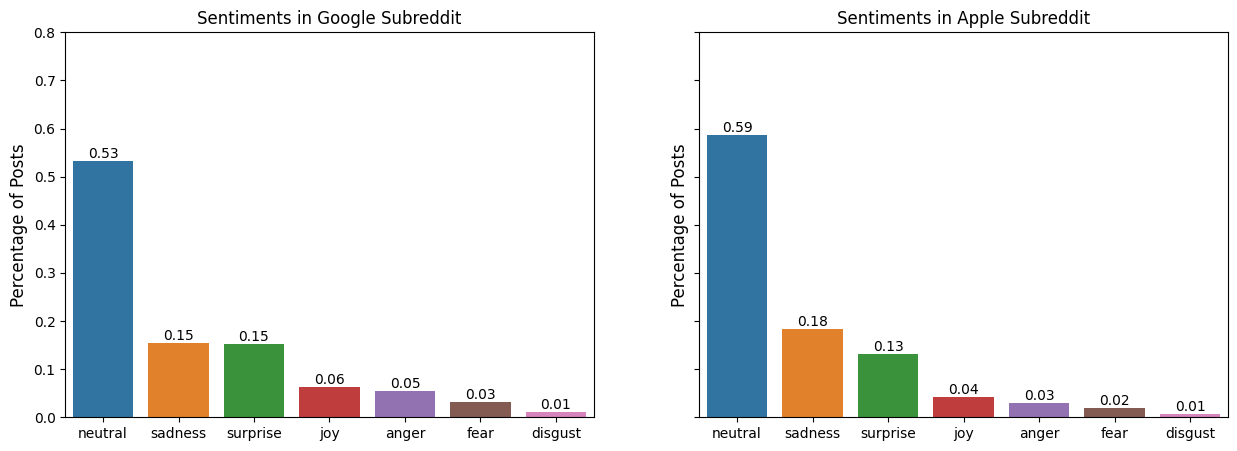

In [242]:
# Plot the sentiment distribution
sentiment_plot(short_text_data,'emotion_label')

In [252]:
# Quick scan of posts labelled as 'sad'
short_text_data.loc[short_text_data['emotion_label'] == 'sadness',['text']].tail(10)

,text
35969,apple watch widgets will not update
35972,cannot find airpods pro find my is broken
35974,i need a refund apple
35975,i need a refund appleindia apple
35984,need to change my apple id email
35987,the iphone mini is not listed on apples official online store anymore
35994,bought iphone dropped it on first day small crackscratch on screen which is very very annoying
36004,ipod classic missing files after connecting to imazing
36034,will i lose my one time purchase appstore
36038,apple magic keyboard issue


In [251]:
# Quick scan of posts labelled as 'surprise'
short_text_data.loc[short_text_data['emotion_label'] == 'surprise',['text']].tail(10)

,text
36002,why do my airpods connect to the wrong devices
36003,why are timers being set randomly
36014,apple q results i do not expect significant upside from aapl in h
36029,new monitor to pair with mbp
36030,bought new but turns out refurbished
36035,iphone pro display panels reveal new pillandhole design replacing notch
36048,is the touch id magic keyboard the same feel as the new macbook pro keyboard
36053,what is the point of getting a high device storage if you can always add an icloud storage
36054,what was your first apple product
36056,why does most app charge for subscription


## Summary of Sentiment Analysis

- Generally, most posts are neutral in sentiment. 
- Hugging Face Tranformer captured more negative sentiments in Google subreddit than Apple subreddit. Upon a more granular emotion analysis using Hugging Face Transformer, the most salient emotions were sadness and surprise.
- A quick scan of posts showed that posts labelled as sadness were mostly venting dissatisfaction of certain product/service. Posts labelled as surprise were mostly users' enquiry on product, service or features.